# 0 Env check

In [1]:
# Stage E (XAI) — Robust notebook
import platform, sys
print("Python:", platform.python_version())
!python -c "import torch, torchvision; print('torch', torch.__version__, 'torchvision', torchvision.__version__)"
!pip list | egrep "torch|functorch|grad-cam|lime" || true


Python: 3.11.13
torch 2.6.0+cu124 torchvision 0.21.0+cu124
lime                                  0.2.0.1
pytorch-ignite                        0.5.2
pytorch-lightning                     2.5.2
torch                                 2.6.0+cu124
torchao                               0.10.0
torchaudio                            2.6.0+cu124
torchdata                             0.11.0
torchinfo                             1.8.0
torchmetrics                          1.7.3
torchsummary                          1.5.1
torchtune                             0.6.1
torchvision                           0.21.0+cu124


# 1 Remove conflict (functorch) and (optionally) restart

In [2]:
# If functorch exists with torch 2.x, it can crash the kernel. Remove it.
!pip show functorch || echo "functorch not installed"
!pip uninstall -y functorch || true
print("If 'functorch' was uninstalled, consider: Runtime → Restart & run all.")


functorch not installed
If 'functorch' was uninstalled, consider: Runtime → Restart & run all.


#  2 Config

In [3]:
from pathlib import Path

# ======= EDIT THESE =======
DATA_ROOT = Path("/kaggle/input/a-dataset-of-citrus-fruit-images/A Dataset of Citrus Fruit Images/CitrusFruit/Augmentation")

BEST_MODEL = "custom_cnn"     # "custom_cnn" | "transfer" | "vit"
BEST_MODEL_PATH = "/kaggle/input/citrus-fruit-custom-cnn/pytorch/default/1/custom_cnn_best.pt"

# Workload knobs (safe defaults)
IM_SIZE       = 224
NUM_SAMPLES   = 10      # explain first N test images (raise to 10 for final)
LIME_SAMPLES  = 1000    # lighter than 1000 to avoid crashes
ABLATION_BS   = 8
BATCH_SIZE    = 16
NUM_WORKERS   = 2

SAVE_DIR = Path("./xai_outputs"); SAVE_DIR.mkdir(exist_ok=True, parents=True)

# Normalization rule: CNNs used ImageNet stats; our ViT used 0.5/0.5/0.5
USE_IMAGENET_NORM = (BEST_MODEL != "vit")
print("USE_IMAGENET_NORM =", USE_IMAGENET_NORM)


USE_IMAGENET_NORM = True


# 3 Core imports, seed, device

In [4]:
import os, json, random, time, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.metrics import classification_report, confusion_matrix

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


# 4 Data (loaders with correct normalization)

In [5]:
# Cell 4B — Fast subset loader (no full tree scan)
from pathlib import Path
from PIL import Image

if USE_IMAGENET_NORM:
    MEAN, STD = [0.485,0.456,0.406], [0.229,0.224,0.225]
else:
    MEAN, STD = [0.5,0.5,0.5], [0.5,0.5,0.5]

eval_tfms = transforms.Compose([
    transforms.Resize((IM_SIZE, IM_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])

def discover_classes(root: Path):
    # class folders are direct children of root (e.g., root/<class_name>/*.jpg)
    classes = sorted([p.name for p in root.iterdir() if p.is_dir()])
    class_to_idx = {c:i for i,c in enumerate(classes)}
    return classes, class_to_idx

def take_first_k_images_per_class(root: Path, k_per_class: int = 20):
    # Gather only a small, sorted subset per class to avoid long os.walk
    classes, class_to_idx = discover_classes(root)
    samples = []
    for cls in classes:
        cdir = root / cls
        # common image suffixes; sorted for determinism
        files = sorted([f for f in cdir.rglob("*") if f.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".webp",".tif",".tiff"}])
        if not files:
            continue
        for f in files[:k_per_class]:
            samples.append((f, class_to_idx[cls]))
    return classes, samples

class TinyImageListDataset(torch.utils.data.Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, label

# How many files to list per class. We only need enough to cover NUM_SAMPLES safely.
# If you set NUM_SAMPLES=6, 20 per class is plenty.
FILES_PER_CLASS = max(20, NUM_SAMPLES * 2)

# Build tiny validation / test sets without a full filesystem walk
classes_val, val_samples  = take_first_k_images_per_class(DATA_ROOT / "Val-A",  k_per_class=FILES_PER_CLASS)
classes_tst, test_samples = take_first_k_images_per_class(DATA_ROOT / "Test-A", k_per_class=FILES_PER_CLASS)

# Keep a single class ordering (prefer Test-A ordering, else Val-A)
CLASSES = classes_tst if classes_tst else classes_val
NUM_CLASSES = len(CLASSES)
assert NUM_CLASSES > 0, "No classes found. Check DATA_ROOT and folder names (Val-A, Test-A)."

# If Val-A had a different class ordering, remap its labels to our CLASSES
cls_to_idx = {c:i for i,c in enumerate(CLASSES)}
def remap(samples, old_classes):
    if old_classes == CLASSES:
        return samples
    old_map = {c:i for i,c in enumerate(old_classes)}
    out = []
    for path, old_lbl in samples:
        c_name = [c for c, i in old_map.items() if i == old_lbl][0]
        out.append((path, cls_to_idx[c_name]))
    return out

val_samples  = remap(val_samples,  classes_val)
test_samples = remap(test_samples, classes_tst)

val_ds  = TinyImageListDataset(val_samples,  transform=eval_tfms)
test_ds = TinyImageListDataset(test_samples, transform=eval_tfms)

print("Classes:", CLASSES)
print("Val  samples:", len(val_ds),  "| Test samples:", len(test_ds))

val_loader  = DataLoader(val_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)


Classes: ['murcott', 'ponkan', 'tangerine', 'tankan']
Val  samples: 80 | Test samples: 80


# 5 Model skeletons + load weights

In [ ]:
import torchvision.models as tvm
from torchvision.models.vision_transformer import ViT_B_16_Weights

# ---- Stage B: CitrusNet (custom CNN) ----
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1, p_drop=0.0):
        super().__init__()
        self.dw = nn.Conv2d(in_ch, in_ch, 3, stride=stride, padding=1, groups=in_ch, bias=False)
        self.dw_bn = nn.BatchNorm2d(in_ch)
        self.pw = nn.Conv2d(in_ch, out_ch, 1, bias=False)
        self.pw_bn = nn.BatchNorm2d(out_ch)
        self.drop = nn.Dropout(p_drop) if p_drop>0 else nn.Identity()
    def forward(self, x):
        x = F.relu(self.dw_bn(self.dw(x)), inplace=True)
        x = F.relu(self.pw_bn(self.pw(x)), inplace=True)
        x = self.drop(x); return x

class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1, p_drop=0.0):
        super().__init__()
        self.conv = DepthwiseSeparableConv(in_ch, out_ch, stride=stride, p_drop=p_drop)
        self.proj = None
        if stride != 1 or in_ch != out_ch:
            self.proj = nn.Sequential(nn.Conv2d(in_ch, out_ch, 1, stride=stride, bias=False),
                                      nn.BatchNorm2d(out_ch))
    def forward(self, x):
        out = self.conv(x)
        res = x if self.proj is None else self.proj(x)
        return F.relu(out + res, inplace=True)

class CitrusNet(nn.Module):
    def __init__(self, num_classes=4, width=(32,64,128,256), p_drop=0.10):
        super().__init__()
        w1, w2, w3, w4 = width
        self.stem  = nn.Sequential(nn.Conv2d(3, w1, 3, stride=2, padding=1, bias=False),
                                   nn.BatchNorm2d(w1), nn.ReLU(inplace=True))
        self.stage1 = ResidualBlock(w1,  w2, stride=1, p_drop=p_drop)
        self.stage2 = ResidualBlock(w2,  w2, stride=1, p_drop=p_drop)
        self.stage3 = ResidualBlock(w2,  w3, stride=2, p_drop=p_drop)
        self.stage4 = ResidualBlock(w3,  w3, stride=1, p_drop=p_drop)
        self.stage5 = ResidualBlock(w3,  w4, stride=2, p_drop=p_drop)
        self.stage6 = ResidualBlock(w4,  w4, stride=1, p_drop=p_drop)
        self.head   = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(0.30), nn.Linear(w4, num_classes))
    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x); x = self.stage2(x)
        x = self.stage3(x); x = self.stage4(x)
        x = self.stage5(x); x = self.stage6(x)
        x = self.head(x);   return x

# ---- Stage C: TL factory ----  (By Deb)
def make_tl_model(name: str, num_classes: int):
    n = name.lower()
    if n == "resnet34":
        m = tvm.resnet34(weights=tvm.ResNet34_Weights.DEFAULT)
        in_feats = m.fc.in_features; m.fc = nn.Linear(in_feats, num_classes)
        target_layer = m.layer4[-1].conv2
    elif n == "densenet121":
        m = tvm.densenet121(weights=tvm.DenseNet121_Weights.DEFAULT)
        in_feats = m.classifier.in_features; m.classifier = nn.Linear(in_feats, num_classes)
        target_layer = m.features.denseblock4.denselayer16.conv2
    elif n == "efficientnet_b0":
        m = tvm.efficientnet_b0(weights=tvm.EfficientNet_B0_Weights.DEFAULT)
        in_feats = m.classifier[1].in_features; m.classifier[1] = nn.Linear(in_feats, num_classes)
        target_layer = m.features[-1][0]
    elif n == "convnext_tiny":
        m = tvm.convnext_tiny(weights=tvm.ConvNeXt_Tiny_Weights.DEFAULT)
        in_feats = m.classifier[2].in_features; m.classifier[2] = nn.Linear(in_feats, num_classes)
        target_layer = m.features[-1][-1].block[2]
    else:
        raise ValueError("Unknown TL backbone")
    return m, target_layer

# ---- Stage D: ViT ----
def create_vit_model(num_classes: int):
    vit = tvm.vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
    in_feats = vit.heads.head.in_features
    vit.heads.head = nn.Linear(in_feats, num_classes)
    return vit

# ---- Build + load ----
BEST_NAME = Path(BEST_MODEL_PATH).name.lower()
if BEST_MODEL == "custom_cnn":
    model = CitrusNet(num_classes=NUM_CLASSES)
    ckpt = torch.load(BEST_MODEL_PATH, map_location="cpu")
    model.load_state_dict(ckpt["model_state"])
    target_hint = ("custom",)
elif BEST_MODEL == "transfer":
    guess = BEST_NAME.replace("tl_","").replace("_best.pt","")
    model, target_layer = make_tl_model(guess, NUM_CLASSES)
    ckpt = torch.load(BEST_MODEL_PATH, map_location="cpu")
    model.load_state_dict(ckpt["model_state"])
    target_hint = ("tl", target_layer)
elif BEST_MODEL == "vit":
    model = create_vit_model(NUM_CLASSES)
    ckpt = torch.load(BEST_MODEL_PATH, map_location="cpu")
    model.load_state_dict(ckpt["model_state"])
    target_hint = ("vit",)
else:
    raise ValueError("BEST_MODEL must be 'custom_cnn' | 'transfer' | 'vit'")

model = model.to(device).eval()
print("Loaded:", BEST_MODEL, "| weights:", BEST_MODEL_PATH)


Loaded: custom_cnn | weights: /kaggle/input/citrus-fruit-custom-cnn/pytorch/default/1/custom_cnn_best.pt


# 6 Try to import XAI libs; set fallbacks if Internet is off

In [ ]:
# Try to use external XAI libs; if Kaggle Internet is down, fall back to pure-PyTorch Grad-CAM/++.  (By Deb)


HAVE_GRADCAM = True
HAVE_LIME = True
try:
    from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenCAM, AblationCAM
    from pytorch_grad_cam.utils.image import show_cam_on_image
except Exception as e:
    print("grad-cam not available:", e)
    HAVE_GRADCAM = False

try:
    from lime import lime_image
    from skimage.segmentation import mark_boundaries
except Exception as e:
    print("lime not available:", e)
    HAVE_LIME = False

# Fallback overlay util if grad-cam package missing

import cv2
import numpy as np

def overlay_heatmap(rgb01, heat):
    """
    rgb01: HxWx3 float in [0,1]
    heat:  HxW (any size) float CAM map
    """
    # ensure single-channel 2D
    if heat.ndim == 3:
        heat = np.squeeze(heat)
    # resize CAM to image size
    H, W = rgb01.shape[:2]
    heat = cv2.resize(heat.astype(np.float32), (W, H), interpolation=cv2.INTER_CUBIC)
    # normalize 0..1
    heat = (heat - heat.min()) / (heat.max() - heat.min() + 1e-6)
    # apply colormap (BGR->RGB)
    hm = cv2.applyColorMap((heat * 255).astype(np.uint8), cv2.COLORMAP_JET)[:, :, ::-1] / 255.0
    out = 0.5 * rgb01 + 0.5 * hm
    return np.clip(out, 0, 1)



grad-cam not available: No module named 'pytorch_grad_cam'


# 7 Helpers (denorm, target layer, fallback Grad-CAM/++)

In [ ]:
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406]); IMAGENET_STD = np.array([0.229, 0.224, 0.225])
HALF_MEAN = np.array([0.5, 0.5, 0.5]); HALF_STD = np.array([0.5, 0.5, 0.5])

def to_rgb01(img_tensor):
    x = img_tensor.detach().cpu().numpy().transpose(1,2,0)
    mean = IMAGENET_MEAN if USE_IMAGENET_NORM else HALF_MEAN
    std  = IMAGENET_STD  if USE_IMAGENET_NORM else HALF_STD
    x = (x * std) + mean
    return np.clip(x, 0, 1)

def choose_target_layer(model, hint):
    if hint[0] == "tl":
        return hint[1]
    if hint[0] == "vit":
        # select a layer norm in the last encoder block
        for n, m in reversed(list(model.named_modules())):
            if "encoder.layers" in n and ("ln_1" in n or "layernorm1" in n):
                return m
        return list(model.modules())[-2]
    if hint[0] == "custom":
        return model.stage6.conv.pw if hasattr(model.stage6, "conv") else list(model.modules())[-3]
    raise ValueError("unknown hint")

# ---------- Fallback: pure-PyTorch Grad-CAM / Grad-CAM++ ----------  (By Deb)
def _backprop_to_layer(model, x, target_layer, target_class=None):
    activations = {}
    gradients = {}
    def fwd_hook(_, __, out): activations['value'] = out
    def bwd_hook(_, grad_in, grad_out): gradients['value'] = grad_out[0]
    h1 = target_layer.register_forward_hook(fwd_hook)
    h2 = target_layer.register_full_backward_hook(bwd_hook)
    model.zero_grad(set_to_none=True)
    logits = model(x)
    if target_class is None: target_class = logits.argmax(1).item()
    score = logits[:, target_class]
    score.backward(retain_graph=True)
    A  = activations['value'].detach()  # [1,C,H,W]
    dA = gradients['value'].detach()    # [1,C,H,W]
    h1.remove(); h2.remove()
    return A, dA, target_class

def gradcam_map(A, dA):
    w = dA.mean(dim=(2,3), keepdim=True)       # [1,C,1,1]
    cam = torch.relu((w * A).sum(dim=1, keepdim=True))
    cam = cam / (cam.max() + 1e-6)
    return cam[0,0].cpu().numpy()

def gradcampp_map(A, dA):
    d2 = dA ** 2; d3 = dA ** 3
    sumA = A.sum(dim=(2,3), keepdim=True) + 1e-6
    alpha = d2 / (2*d2 + (A * d3 * 4 * sumA) + 1e-6)
    w = (alpha * torch.relu(dA)).sum(dim=(2,3), keepdim=True)  # [1,C,1,1]
    cam = torch.relu((w * A).sum(dim=1, keepdim=True))
    cam = cam / (cam.max() + 1e-6)
    return cam[0,0].cpu().numpy()


In [9]:
# Cell 7.5 — Helper for LIME (predict_proba_numpy)
def predict_proba_numpy(X):
    """
    X: numpy array [N, H, W, 3] in uint8 or 0..255 float.
    Returns: numpy array [N, NUM_CLASSES] of probabilities.
    """
    arr = X.astype(np.float32) / 255.0
    # normalize exactly like eval_tfms
    mean = np.array(MEAN, dtype=np.float32)
    std  = np.array(STD,  dtype=np.float32)
    arr = (arr - mean) / std
    arr = np.transpose(arr, (0,3,1,2))  # NHWC -> NCHW
    t = torch.from_numpy(arr).to(device)
    with torch.no_grad():
        logits = model(t)
        probs = torch.softmax(logits, dim=1).detach().cpu().numpy()
    return probs


# 8 XAI loop (safe mode; uses fallbacks if needed)

In [10]:
# Cell 8 — XAI loop (safe mode; uses fallbacks if needed)
from tqdm import tqdm

target_layer = choose_target_layer(model, target_hint)
use_cuda = (device.type == "cuda")

rows = []
images_done = 0

for imgs, labels in tqdm(test_loader, total=len(test_loader)):
    for i in range(imgs.size(0)):
        if images_done >= NUM_SAMPLES: break
        img_cpu = imgs[i]
        rgb01 = to_rgb01(img_cpu)
        img_t  = img_cpu.to(device)
        label  = int(labels[i].item())

        with torch.no_grad():
            logits = model(img_t.unsqueeze(0))
            probs = torch.softmax(logits, dim=1)[0].detach().cpu().numpy()
            pred_idx = int(np.argmax(probs))
            pred_prob = float(probs[pred_idx])

        cam_visuals = {}

        if HAVE_GRADCAM:
            cam_defs = {
                "gradcam":      (GradCAM, {}),
                "gradcam_pp":   (GradCAMPlusPlus, {}),
                "eigencam":     (EigenCAM, {}),
                "ablationcam":  (AblationCAM, {"batch_size": ABLATION_BS}),
            }
            for name, (CAMcls, extra) in cam_defs.items():
                cam = CAMcls(model=model, target_layers=[target_layer], use_cuda=use_cuda, **extra)
                grayscale = cam(input_tensor=img_t.unsqueeze(0))
                vis = show_cam_on_image(rgb01.astype(np.float32), grayscale[0], use_rgb=True)
                cam_visuals[name] = vis
        else:
            A, dA, _ = _backprop_to_layer(model, img_t.unsqueeze(0), target_layer, target_class=pred_idx)
            heat_g = gradcam_map(A, dA)
            heat_p = gradcampp_map(A, dA)
            cam_visuals["gradcam"]    = overlay_heatmap(rgb01, heat_g)
            cam_visuals["gradcam_pp"] = overlay_heatmap(rgb01, heat_p)

        # ---- LIME (optional) ----
        lime_vis = None
        if HAVE_LIME:
            from lime import lime_image
            from skimage.segmentation import mark_boundaries
            explainer = lime_image.LimeImageExplainer()
            img_uint8 = (rgb01 * 255).astype(np.uint8)
            explanation = explainer.explain_instance(
                img_uint8,
                classifier_fn=lambda X: predict_proba_numpy(X),
                top_labels=1,
                num_samples=LIME_SAMPLES,
                hide_color=0
            )
            tlab = explanation.top_labels[0]
            lime_img, lime_mask = explanation.get_image_and_mask(
                tlab, positive_only=True, num_features=10, hide_rest=False
            )
            lime_vis = mark_boundaries(lime_img, lime_mask)

        # ---- Build dynamic panel list ----
        panel_names = ["input"]
        for k in ["gradcam", "gradcam_pp", "eigencam", "ablationcam"]:
            if k in cam_visuals:
                panel_names.append(k)
        if lime_vis is not None:
            panel_names.append("lime")

        cols = len(panel_names)
        fig, axes = plt.subplots(1, cols, figsize=(3*cols, 3))
        if cols == 1:
            axes = [axes]
        else:
            axes = np.ravel(axes)

        col = 0
        # Input
        axes[col].imshow(rgb01)
        axes[col].set_title(f"Input\ntrue={CLASSES[label]}\npred={CLASSES[pred_idx]}:{pred_prob:.2f}")
        axes[col].axis("off")
        col += 1

        # CAMs
        for name in ["gradcam", "gradcam_pp", "eigencam", "ablationcam"]:
            if name in cam_visuals:
                axes[col].imshow(cam_visuals[name])
                axes[col].set_title(name.replace("_", "-").title())
                axes[col].axis("off")
                col += 1

        # LIME
        if lime_vis is not None:
            axes[col].imshow(lime_vis)
            axes[col].set_title("LIME")
            axes[col].axis("off")
            col += 1

        fname = SAVE_DIR / f"xai_{images_done:02d}_true-{CLASSES[label]}_pred-{CLASSES[pred_idx]}.png"
        plt.tight_layout()
        plt.savefig(fname, dpi=150)
        plt.close(fig)

        rows.append({
            "index": images_done,
            "true": CLASSES[label],
            "pred": CLASSES[pred_idx],
            "pred_prob": pred_prob,
            "file": str(fname)
        })
        images_done += 1
    if images_done >= NUM_SAMPLES: break

df_xai = pd.DataFrame(rows)
display(df_xai)
csv_path = SAVE_DIR / "xai_index.csv"
df_xai.to_csv(csv_path, index=False)
print("Saved:", csv_path, "and", len(df_xai), "figures in", SAVE_DIR)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [03:46<?, ?it/s]


,index,true,pred,pred_prob,file
0,0,murcott,murcott,0.547489,xai_outputs/xai_00_true-murcott_pred-murcott.png
1,1,murcott,ponkan,0.755815,xai_outputs/xai_01_true-murcott_pred-ponkan.png
2,2,murcott,murcott,0.887520,xai_outputs/xai_02_true-murcott_pred-murcott.png
3,3,murcott,murcott,0.820638,xai_outputs/xai_03_true-murcott_pred-murcott.png
4,4,murcott,murcott,0.871205,xai_outputs/xai_04_true-murcott_pred-murcott.png
5,5,murcott,murcott,0.914355,xai_outputs/xai_05_true-murcott_pred-murcott.png
6,6,murcott,murcott,0.645545,xai_outputs/xai_06_true-murcott_pred-murcott.png
7,7,murcott,murcott,0.990797,xai_outputs/xai_07_true-murcott_pred-murcott.png
8,8,murcott,murcott,0.994956,xai_outputs/xai_08_true-murcott_pred-murcott.png
9,9,murcott,murcott,0.926771,xai_outputs/xai_09_true-murcott_pred-murcott.png


Saved: xai_outputs/xai_index.csv and 10 figures in xai_outputs


# 9 — Preview & Zip

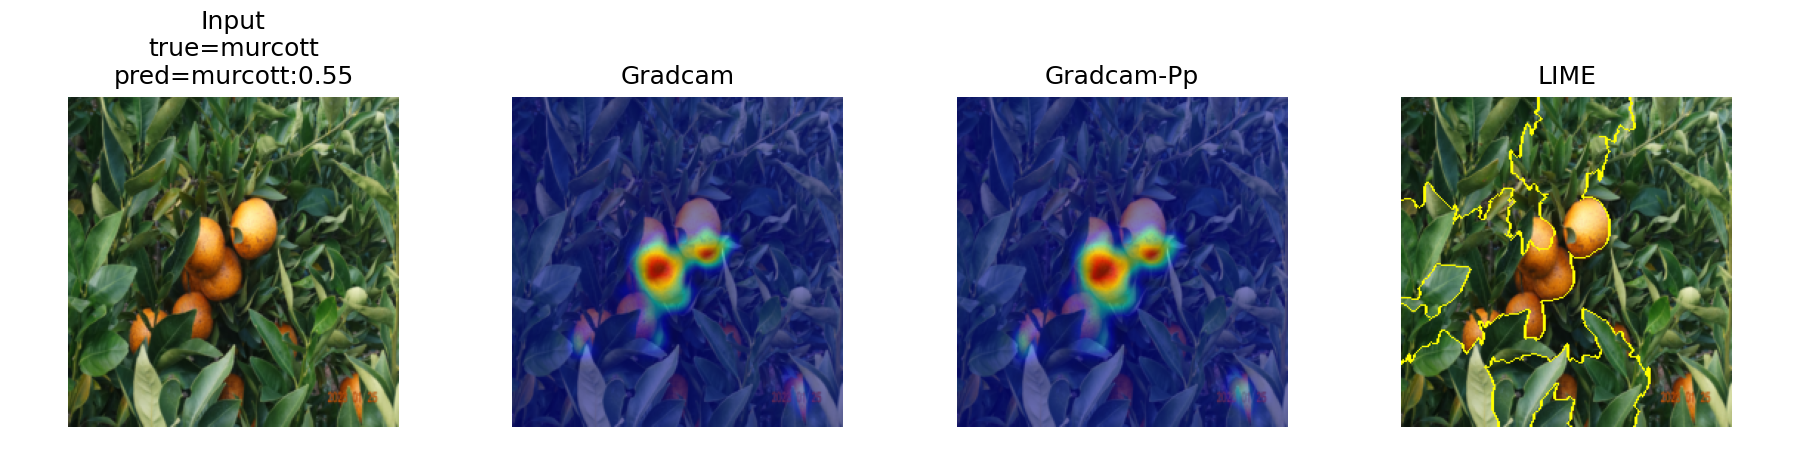

Zipped -> xai_outputs.zip


In [11]:
from IPython.display import Image, display
if len(df_xai): display(Image(filename=df_xai.iloc[0]["file"]))

zip_path = "xai_outputs.zip"
shutil.make_archive("xai_outputs", "zip", SAVE_DIR)
print("Zipped ->", zip_path)
